# Model 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import scipy

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from skmultilearn.model_selection import iterative_train_test_split
# from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.adapt import MLkNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

# from sklearnex import patch_sklearn
# patch_sklearn()

2022-10-10 21:07:36.446959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 21:07:36.963652: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 21:07:38.356443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/bryan/miniconda3/envs/tf/lib/
2022-10-10 21:07:38.356713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
# Read in the pickle file

with open('../saved_file/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under username h...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,aww match this background colour seemingly sti...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man really not try edit war just that this...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more cannot make any real suggestions improvem...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir hero any chance you remember what page...


# Train test split

In [4]:
# Taking a subset of the data for faster processing

# df_train = df_train.sample(1000, random_state=42)

In [5]:
# train test split

features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X = df_train["cleaned_comment_text"]
y = df_train[features]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.values.reshape(-1, 1), y.values, test_size=0.3,
)

In [6]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(111699, 1)

(111699, 6)

(47872, 1)

(47872, 6)

# scikit-learn estimators that have multi-learning support built-in


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe_n = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('nn', KNeighborsClassifier(n_neighbors=3, n_jobs=-1)),
])

In [ ]:
pipe_n.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('nn', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

In [ ]:
y_pred = pipe_n.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9034926470588235

0.3694806215348379

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('rf', RandomForestClassifier(random_state=42, max_depth=5, n_jobs=-1, class_weight='balanced')),
])

In [ ]:
pipe_rf.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_jobs=-1, random_state=42))])

In [ ]:
y_pred = pipe_rf.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.00027155748663101604

0.12319412825100758

# One vs rest classifier

This classifier can also be used for multilabel classification.

In [41]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=10_000), n_jobs=-1, )),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=10000),
                                     n_jobs=-1))])

In [42]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.874456885026738

0.6915746891123729

In [43]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('mnb', OneVsRestClassifier(MultinomialNB(), n_jobs=-1)),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('mnb',
                 OneVsRestClassifier(estimator=MultinomialNB(), n_jobs=-1))])

In [44]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.903555314171123

0.37037938011539645

In [45]:
# Pipeline

pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('svc', OneVsRestClassifier(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

In [46]:
pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('svc',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced',
                                                         max_iter=10000)))])

In [48]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8818098262032086

0.6911559534288386

In [60]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[43250,    34],
        [ 3090,  1498]],

       [[47393,     0],
        [  479,     0]],

       [[45321,    16],
        [ 1884,   651]],

       [[47729,     0],
        [  143,     0]],

       [[45473,    36],
        [ 2006,   357]],

       [[47450,     0],
        [  422,     0]]])

# Multioutput classifier

In [50]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=10_000, n_jobs=-1))),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    n_jobs=-1)))])

In [51]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.874456885026738

0.6915746891123729

In [53]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log', MultiOutputClassifier(estimator=MultinomialNB()))])

In [54]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.903555314171123

0.37037938011539645

In [55]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', MultiOutputClassifier(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 MultiOutputClassifier(estimator=LinearSVC(class_weight='balanced',
                                                           max_iter=10000)))])

In [56]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8818098262032086

0.6911559534288386

# ClassifierChain

In [17]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95,max_features=3000)),
    ('log', ClassifierChain(LogisticRegression(class_weight='balanced', max_iter=10_000, n_jobs=-1))),
])

pipe_log.fit(X_train.ravel(), y_train)

KeyboardInterrupt: 

In [60]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.862863469251337

0.6139030550824732

In [61]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', ClassifierChain(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log', ClassifierChain(base_estimator=MultinomialNB()))])

In [62]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9095086898395722

0.4871984457196693

In [63]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95)),
    ('log', ClassifierChain(LinearSVC(class_weight='balanced', max_iter=10_000))),
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 ClassifierChain(base_estimator=LinearSVC(class_weight='balanced',
                                                          max_iter=10000)))])

In [64]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8839613970588235

0.6748073526295787

# Trying out the adapted algorithm

## Label Powerset

In [6]:
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('log', LabelPowerset(LogisticRegression(class_weight='balanced', max_iter=10_000))),
])

pipe_log.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 LabelPowerset(classifier=LogisticRegression(class_weight='balanced',
                                                             max_iter=10000),
                               require_dense=[True, True]))])

In [8]:
y_pred = pipe_log.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.7514622326203209

0.47729799265999495

In [8]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('log', LabelPowerset(MultinomialNB())),
])

pipe_nb.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('log',
                 LabelPowerset(classifier=MultinomialNB(),
                               require_dense=[True, True]))])

In [9]:
y_pred = pipe_nb.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.9106366978609626

0.49536072546951543

In [12]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=2, max_df=0.95, max_features=3000)),
    ('svc', LabelPowerset(LinearSVC(class_weight='balanced', max_iter=10_000, C=0.1)))
])

pipe_svc.fit(X_train.ravel(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=3000, min_df=2,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('svc',
                 LabelPowerset(classifier=LinearSVC(C=0.1,
                                                    class_weight='balanced',
                                                    max_iter=10000),
                               require_dense=[True, True]))])

In [13]:
y_pred = pipe_svc.predict(X_test.ravel())
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred, average='weighted'))

0.8792404745989305

0.6187202274476172

# Neural Network

In [31]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [43]:
max_features = 5000
vectorizer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=400)

In [44]:
vectorizer.adapt(df_train['comment_text'], batch_size=16)

In [45]:
# vectorizer.get_vocabulary()

In [46]:
# vectorizer("Hello word, life is great")

In [47]:
vectorized_text = vectorizer(df_train['comment_text'])

In [48]:
# vectorized_text

In [55]:
# MCSHBAP - map, cache, shuffle, batch, prefetch
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, df_train[labels].values))
dataset = dataset.cache()
dataset = dataset.shuffle(160000).batch(16)
dataset = dataset.prefetch(8)

In [56]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [57]:
batch_X.shape

(16, 400)

In [58]:
# train test split

train = dataset.take(int(len(dataset)*0.7))
test = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.3))

## Deep learning

In [59]:
model = Sequential()
# Create the emedding layer
model.add(Embedding(max_features+1, 32))
# Create the LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [60]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          160032    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [64]:
print(tf.test.gpu_device_name())

/device:GPU:0


2022-10-10 22:00:04.932061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:00:04.932435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:00:04.932680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:00:04.932938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:00:04.933098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [65]:
EPOCHS = 30
checkpoint_filepath = '../model_checkpoints/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [66]:
history = model.fit(train, epochs=EPOCHS, validation_data=test, callbacks=[model_checkpoint_callback], verbose=1, batch_size=16)

Epoch 1/30
6981/6981 [==============================] - 129s 19ms/step - loss: 0.0584 - accuracy: 0.9915 - val_loss: 0.0526 - val_accuracy: 0.9943
Epoch 2/30
6981/6981 [==============================] - 133s 19ms/step - loss: 0.0517 - accuracy: 0.9888 - val_loss: 0.0491 - val_accuracy: 0.9946
Epoch 3/30
6981/6981 [==============================] - 133s 19ms/step - loss: 0.0489 - accuracy: 0.9930 - val_loss: 0.0478 - val_accuracy: 0.9939
Epoch 4/30
6981/6981 [==============================] - 135s 19ms/step - loss: 0.0463 - accuracy: 0.9920 - val_loss: 0.0430 - val_accuracy: 0.9765
Epoch 5/30
6981/6981 [==============================] - 135s 19ms/step - loss: 0.0437 - accuracy: 0.9708 - val_loss: 0.0414 - val_accuracy: 0.9946
Epoch 6/30
6981/6981 [==============================] - 134s 19ms/step - loss: 0.0422 - accuracy: 0.9842 - val_loss: 0.0386 - val_accuracy: 0.9942
Epoch 7/30
6981/6981 [==============================] - 135s 19ms/step - loss: 0.0401 - accuracy: 0.9821 - val_loss: 0

In [26]:
import os

In [28]:
model.save(os.path.join('model1_saved_file', 'model_less_length_ep20.h5'))

In [29]:
# model.save(os.path.join('model1_saved_file', 'model_ep20_gpu2_os.h5'))

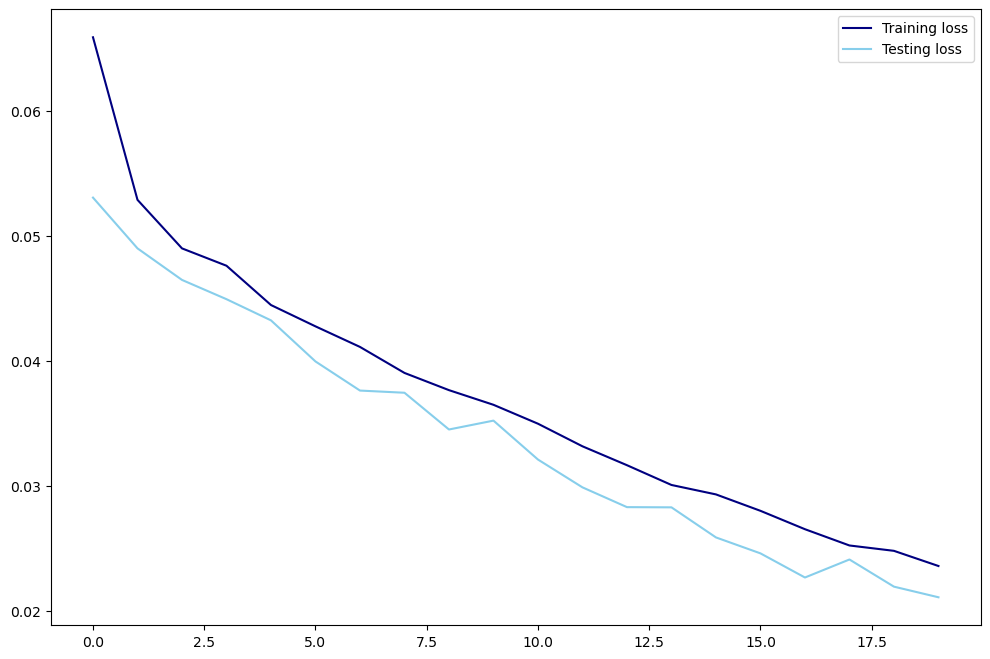

In [30]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [68]:
input_text = vectorizer('You freaking suck!')

In [69]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [70]:
from tensorflow import keras
modelcpu = keras.models.load_model("../model1_saved_file/model_ep10_gpu.h5")

In [71]:
batch = test.as_numpy_iterator().next()

In [72]:
modelcpu.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 546ms/step


array([[0.97911   , 0.05085397, 0.8819269 , 0.01125964, 0.8954124 ,
        0.0599577 ]], dtype=float32)

In [73]:
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

In [74]:
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [75]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = modelcpu.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 42ms/step


In [76]:
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8868181109428406, Recall:0.8576793074607849, Accuracy:0.5190507769584656
